# Abnormal ECG detection
Feature engineering done thanks to AntroPy library from **Raphael Vallat** (Many thanks !)

https://github.com/raphaelvallat/antropy

In [44]:
import sys
import numpy as np
from scipy import stats
import pandas as pd
import random

import entropy
import fractal

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [45]:
def progressbar(it, prefix="", size=60, out=sys.stdout):
    '''
    https://stackoverflow.com/questions/3160699/python-progress-bar
    '''
    count = len(it)
    def show(j):
        x = int(size*j/count)
        out.write("%s[%s%s] %i/%i\r" % (prefix, u"#"*x, "."*(size-x), j, count))
        out.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    out.write("\n")
    out.flush()

In [128]:
df_normal_all = pd.read_csv('ptbdb_normal.csv',header=None)
df_normal_all = df_normal_all.sample(df_normal_all.shape[0])
df_normal = df_normal_all[:3000].reset_index(drop=True)

# Abnormal TS all have their last value (column 187) to 1
df_abnormal_all = pd.read_csv('ptbdb_abnormal.csv',header=None).drop(187,axis=1)
df_abnormal_all = df_abnormal_all.sample(df_abnormal_all.shape[0])
df_abnormal = df_abnormal_all[:3000].reset_index(drop=True)

# Mix normal and abnormal
df_normal_test = df_normal_all[3000:].sample(500)
df_abnormal_test = df_abnormal_all[3000:].sample(500)

df_normal_test['label'] = 0
df_abnormal_test['label'] = 1
df_test = pd.concat([df_normal_test,df_abnormal_test],ignore_index=True).fillna(0)

In [85]:
# Remove all the filled zeroes to equalize TS size
def pre_processor(arr):
    while arr[-1] == 0:
        arr = arr[:-1].copy()
    return arr

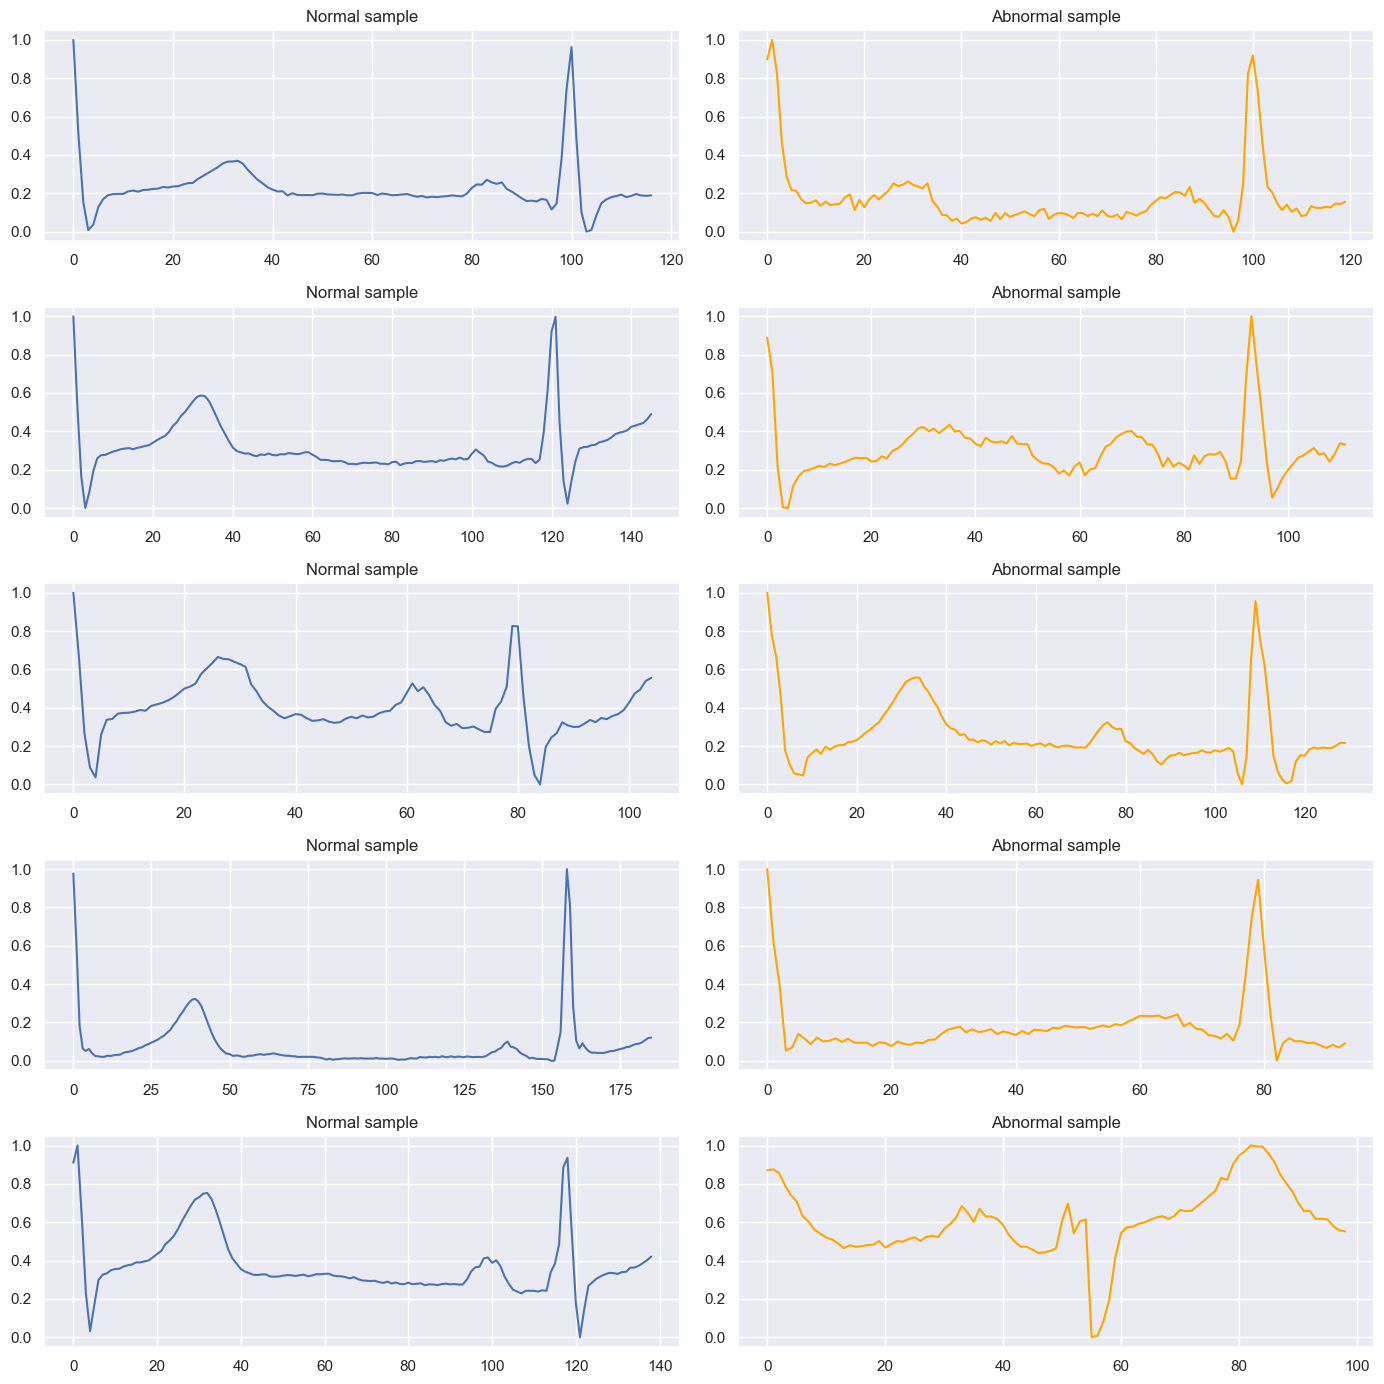

In [86]:
fig,ax=plt.subplots(figsize=(14,14))
c = 1

for idx,idy in zip(random.sample(df_normal.index.tolist(),5),random.sample(df_abnormal.index.tolist(),5)):
    plt.subplot(5,2,c)
    plt.plot(pre_processor(df_normal.iloc[idx].values))
    plt.title('Normal sample')
    plt.subplot(5,2,c+1)
    plt.plot(pre_processor(df_abnormal.iloc[idy].values),color='orange')
    plt.title('Abnormal sample')
    c+=2
plt.tight_layout()

In [87]:
df_FD_normal = pd.DataFrame()
df_FD_abnormal = pd.DataFrame()

print('Processing normal ECG')
for idx in progressbar(range(df_normal.shape[0])):
    signal = pre_processor(df_normal.iloc[idx].values)
    
    row = pd.DataFrame({
        'PermEnt': entropy.perm_entropy(signal, order=3, normalize=True),
        'SVDEnt' : entropy.svd_entropy(signal, order=3, normalize=True),
        'AppEnt': entropy.app_entropy(signal, order=2),
        'SampleEnt': entropy.sample_entropy(signal, order=2),
        'PetrosianFD': fractal.petrosian_fd(signal),
        'KatzFD': fractal.katz_fd(signal),
        'HiguchiFD': fractal.higuchi_fd(signal),
    },index = [0])
    
    df_FD_normal = pd.concat([df_FD_normal, row], ignore_index=True)
    
print('Processing abnormal ECG')
for idx in progressbar(range(df_abnormal.shape[0])):
    signal = pre_processor(df_abnormal.iloc[idx].values)
    
    row = pd.DataFrame({
        'PermEnt': entropy.perm_entropy(signal, order=3, normalize=True),
        'SVDEnt' : entropy.svd_entropy(signal, order=3, normalize=True),
        'AppEnt': entropy.app_entropy(signal, order=2),
        'SampleEnt': entropy.sample_entropy(signal, order=2),
        'PetrosianFD': fractal.petrosian_fd(signal),
        'KatzFD': fractal.katz_fd(signal),
        'HiguchiFD': fractal.higuchi_fd(signal),
    },index = [0])
    
    df_FD_abnormal = pd.concat([df_FD_abnormal, row], ignore_index=True)

Processing normal ECG
[############################################################] 3000/3000
Processing abnormal ECG
[############################################################] 3000/3000


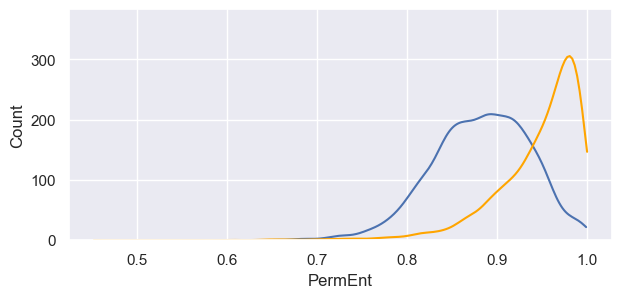

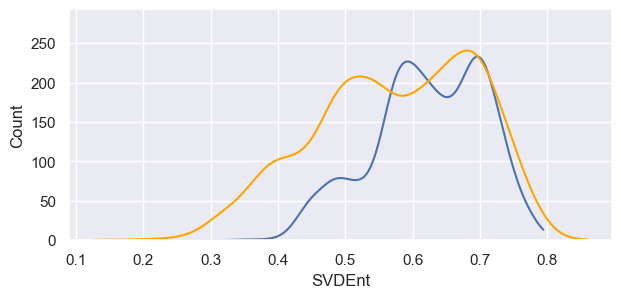

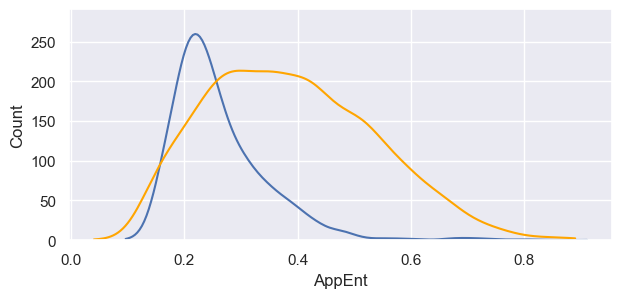

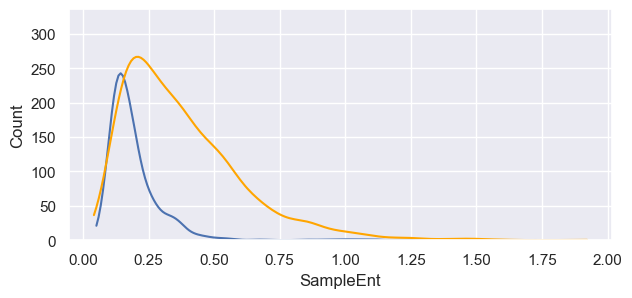

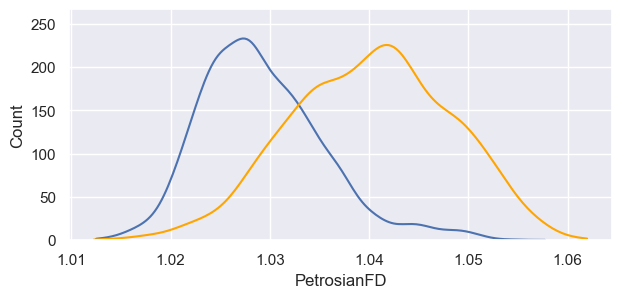

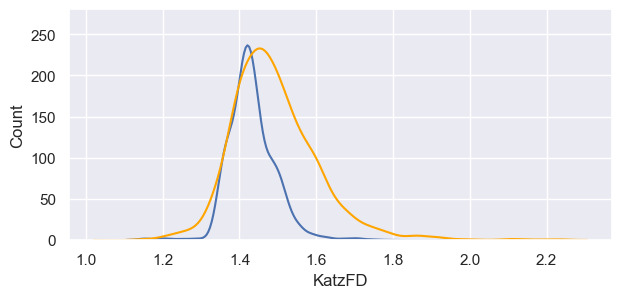

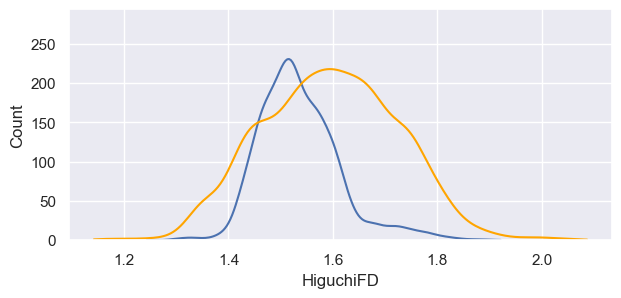

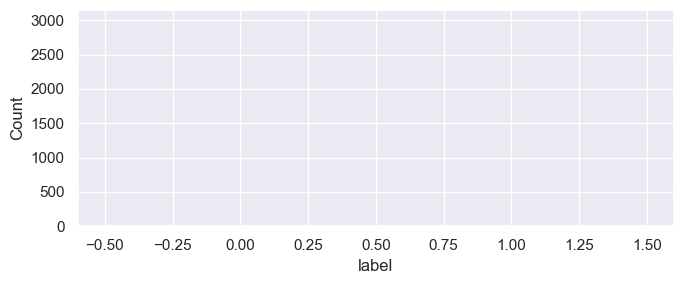

In [126]:
for col in df_FD_normal.columns:
    fig,ax=plt.subplots(figsize=(7,3))
    sns.histplot(df_FD_normal[col],kde=True,alpha=0.,label='normal',linewidth=0)
    sns.histplot(df_FD_abnormal[col],kde=True,color='orange',alpha=0.,label='abnormal',linewidth=0)
    #print(col,stats.ttest_ind(df_FD_normal[col], df_FD_abnormal[col]))

plt.tight_layout()

In [89]:
df_FD_normal['label'] = 0
df_FD_abnormal['label'] = 1

In [90]:
data = pd.concat([df_FD_normal, df_FD_abnormal],ignore_index=True)

In [91]:
data.drop('label',axis=1).columns

Index(['PermEnt', 'SVDEnt', 'AppEnt', 'SampleEnt', 'PetrosianFD', 'KatzFD',
       'HiguchiFD'],
      dtype='object')

In [92]:
ML_features = [
    'PermEnt', 
    'SVDEnt', 
    'AppEnt', 
    'SampleEnt', 
    'PetrosianFD', 
    'KatzFD',
    'HiguchiFD', 
]

In [93]:
X = data[ML_features].values
y = data['label'].values.ravel()

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 42)
skb = SelectKBest(f_classif)

clf = XGBClassifier()
pipeline = Pipeline(steps = [
    ("SKB",skb),
    ("CLF",clf)
])   

param_grid = {
    "SKB__k":['all'],
    "CLF__n_estimators":[200,500]
} 

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = sss)

In [95]:
%%time
grid.fit(X_train, y_train.ravel())
clf = grid.best_estimator_

y_pred = clf.predict(X_test)
print("\n > Best grid search:\n",grid.best_params_,'\n')

print(classification_report(y_test,y_pred))

Fitting 5 folds for each of 2 candidates, totalling 10 fits

 > Best grid search:
 {'CLF__n_estimators': 500, 'SKB__k': 'all'} 

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       600
           1       0.91      0.90      0.90       600

    accuracy                           0.90      1200
   macro avg       0.90      0.90      0.90      1200
weighted avg       0.90      0.90      0.90      1200

Wall time: 28.7 s


In [96]:
pd.DataFrame({
    'features':ML_features,
    'importance':grid.best_estimator_.named_steps['SKB'].scores_
}).sort_values('importance',ascending=False)

,features,importance
4,PetrosianFD,2773.959754
0,PermEnt,1762.434762
2,AppEnt,1304.922852
3,SampleEnt,1189.628233
5,KatzFD,492.903842
6,HiguchiFD,370.212998
1,SVDEnt,284.681075


In [143]:
def random_test():

    idx = random.randint(0,df_test.shape[0])

    signal = df_test.drop('label',axis=1).iloc[idx].values.ravel()
    signal = pre_processor(signal)

    feature_eng = pd.DataFrame({
            'PermEnt': entropy.perm_entropy(signal, order=3, normalize=True),
            'SVDEnt' : entropy.svd_entropy(signal, order=3, normalize=True),
            'AppEnt': entropy.app_entropy(signal, order=2),
            'SampleEnt': entropy.sample_entropy(signal, order=2),
            'PetrosianFD': fractal.petrosian_fd(signal),
            'KatzFD': fractal.katz_fd(signal),
            'HiguchiFD': fractal.higuchi_fd(signal),
        },index = [0])

    display(feature_eng)
    pred = clf.predict_proba(feature_eng[ML_features].values)
    proba = pd.DataFrame(pred,columns=['normal','abnormal'])

    fig,ax=plt.subplots(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.plot(signal, color='r')
    actual = 'Actual: normal' if df_test.label.iloc[idx] == 0 else 'Actual: abnormal'
    plt.title(actual)

    plt.subplot(1,2,2)
    sns.barplot(data=proba)
    plt.ylim(0,1.1)
    predicted = 'Prediction: normal' if pred.argmax() == 0 else 'Prediction: abnormal'
    plt.title(predicted)

    plt.tight_layout()

,PermEnt,SVDEnt,AppEnt,SampleEnt,PetrosianFD,KatzFD,HiguchiFD
0,0.823227,0.704556,0.174578,0.126382,1.021857,1.425194,1.495918


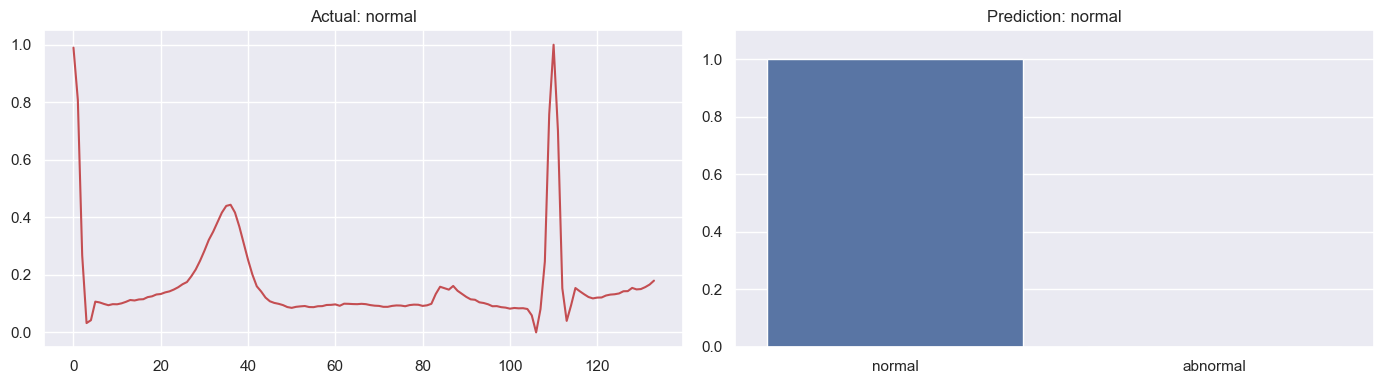

In [147]:
random_test()